## Training to laplacian terms (for diffusion term)

In [3]:
#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.base import advection
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
import jax_cfd.ml.diego_preprocessing as preprocessing
import jax_cfd.ml.diego_train_functions as training
from jax_cfd.ml import nonlinearities
import jax_cfd.ml.diego_cnn_bcs as bcs

import jax_cfd.ml.newSaveObject as saving
import jax_cfd.ml.diego_towers as mytowers

import matplotlib.pyplot as plt
import seaborn

import time

# import tree_math

In [4]:
# this allows me to reload a module without having to interrupt the kernel
import importlib
importlib.reload(mytowers)
# importlib.reload(from jax_cfd.ml.diego_train_functions import *)
# importlib.reload(from jax_cfd.ml import nonlinearities)
# importlib.reload(from jax_cfd.ml.diego_cnn_bcs import *)

<module 'jax_cfd.ml.diego_towers' from '/rds/general/user/dd519/home/FYP/forked_jax/jax-cfd/jax_cfd/ml/diego_towers.py'>

In [5]:
# import data (fine grid)
# create X_data via mean pooling
# create Y_data by calculating everything for each frame and stacking them along the channel dimension

In [6]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [7]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape),
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape)
    ])
    high_def.append(this_time)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 10
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 10
Training dataset shape: 
	(864, 256, 64, 2)


In [9]:
# %time high_def_norm,ogMean,ogStdDev = preprocessing.normalisingDataset(high_def)

In [10]:
# testing_data = high_def[:5]

In [11]:
which_outputs = {
        "vels" : False,
        "derivatives" : False,
        "laplacians" : True
    }

In [12]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = preprocessing.creatingDataset(high_def,preprocessing.sampling,factor)

print("\nCreate Y dataset: ")
padding = [1,1]
%time Y_dataset = preprocessing.getYdata(high_def,which_outputs,padding,preprocessing.sampling,factor) #does everything, returns unpadded data

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]



# print("\nPadding all datasets: ")
# padding = [1,1] #this is for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
# %time X_train = padXDataset(X_train,padding)
# %time Y_train = padYDatasetNew(Y_train,padding,conditions)

# %time X_test = padXDataset(X_test,padding)
# %time Y_test = padYDataset(Y_test,padding,conditions)

print("\nShapes of all datasets")
training.printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 171 ms, sys: 4.98 ms, total: 176 ms
Wall time: 176 ms

Create Y dataset: 
CPU times: user 23.5 s, sys: 42.4 ms, total: 23.5 s
Wall time: 23.6 s

Shapes of all datasets
(691, 64, 16, 2)
(691, 64, 16, 2)
(173, 64, 16, 2)
(173, 64, 16, 2)


## Defining model shape

In [17]:
import importlib
importlib.reload(mytowers)

<module 'jax_cfd.ml.diego_towers' from '/rds/general/user/dd519/home/FYP/forked_jax/jax-cfd/jax_cfd/ml/diego_towers.py'>

In [51]:
def ConvNet(x):
    cnn = mytowers.CNN_Dropout(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 20,
    "hidden_layers" : 6,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [52]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [ ]:
instance = training.MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(42), #rng_key
                      input_channels=2,
                      epochs= 50,
                      printEvery=1,#epochs
                      learning_rates=training.staggeredLearningRate((10,0.05),(20,0.01),(10,0.001)), #iterated over batches
                      batch_size=len(X_train)//2 +1, # number or len(X_train)
                      validateEvery=1,
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(691, 64, 16, 2)
(691, 64, 16, 2)
(173, 64, 16, 2)
(173, 64, 16, 2)



Start time: 12:09:10
Epoch 1/50
	mse : 0.000778		val mse : 0.000822	Estimated end time: 12:48:32


Epoch 2/50
	mse : 0.000760		val mse : 0.000806	Estimated end time: 13:01:20


Epoch 3/50
	mse : 0.000746		val mse : 0.000794	Estimated end time: 13:07:43


Epoch 4/50


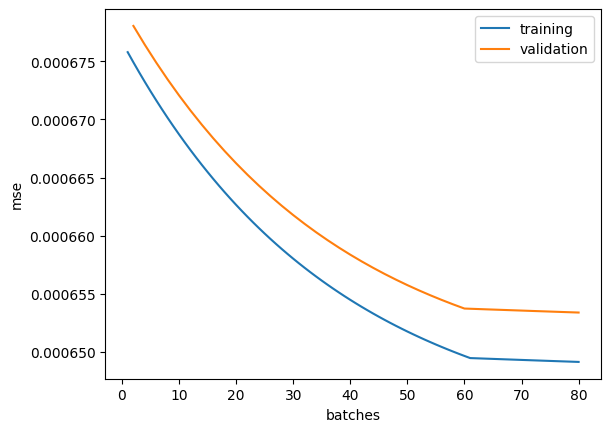

In [15]:

batches = np.arange(len(instance.losses))
val_step = len(instance.losses)//len(instance.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,instance.losses, label="training")
plt.plot(batches_val,instance.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

In [37]:
batches

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
description = "testing rescaling"

In [ ]:
toSave = saving.newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [ ]:
save_path = "./../models/final_models/diffusion_shite3.pickle"

In [41]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

del save_path

## Loading model

In [43]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))
del save_path

In [44]:
loaded.description

'testing rescaling'

## Evaluating the model 

In [45]:
# loss_eval = mse
def loss_eval(in1,in2):
    return abs(in1-in2)

In [46]:
# Make predictions for every slice in X_test
predictions = []
for mySlice in X_test:
    predictions.append(loaded.forward_pass.apply(loaded.params,mySlice))

In [47]:
# Compute error predictions vs Y_test
errors = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(predictions[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errors.append(partial)

In [48]:
# Compute what would have been obtained from input without the CNN (to see if there is an improvement)

In [49]:
# calculate laplacians for input
inputLaps = []
for j in range(len(X_test)):
    inputLaps.append(preprocessing.npLaplacian(X_test[j]))

In [50]:
# Compute error computed laps for input vs true laps
errorsLaps = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(inputLaps[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errorsLaps.append(partial)

In [51]:
print("Test error for NN")
print("\tError : {:.6f}".format(np.mean(errors)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errors) / np.mean(np.abs(Y_test))))

print("\nError if no NN used")
print("\tError : {:.6f}".format(np.mean(errorsLaps)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errorsLaps) / np.mean(np.abs(Y_test))))

Test error for NN
	Error : 0.071051
	Error/mean(||truth||) : 7.574623

Error if no NN used
	Error : 0.049294
	Error/mean(||truth||) : 5.255171
